In [1]:
import os
import sys
import glob
import random
import warnings
import shutil
from distutils.dir_util import copy_tree


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
# from keras.layers.merge import concatenate
from keras.layers import concatenate

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
from tensorflow.keras.metrics import Metric

import skimage.io

In [2]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
# IMG_CHANNELS = 3
IMG_CHANNELS = 1

In [3]:
# the small set for experimentation!
TRAIN_PATH = './FORmodels/trainset_raw/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
len(train_ids)

1809

In [4]:
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
Y_train.shape

/var/folders/qr/np1v1r_53zqc4t2j9qztcrxh0000gn/T/ipykernel_33764/187304916.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)


(1809, 128, 128)

In [5]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    pather = TRAIN_PATH + id_    
    img = imread(pather + '/images/' + id_ + '.png')
    X_train[n] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        
    pattern = pather+'/masks/*'
    for fname in glob.glob(pattern, recursive=True):

        mask_ = imread(fname)     
        mask_ = resize(mask_,(IMG_HEIGHT, IMG_WIDTH, 1))
#         mask_ = np.expand_dims(mask_, axis=1)        
        mask = np.maximum(mask, mask_)
        
    Y_train[n] = mask

Getting and resizing train images and masks ... 


/var/folders/qr/np1v1r_53zqc4t2j9qztcrxh0000gn/T/ipykernel_33764/431872359.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  0%|                                                  | 0/1809 [00:00<?, ?it/s]/var/folders/qr/np1v1r_53zqc4t2j9qztcrxh0000gn/T/ipykernel_33764/431872359.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: http

1348 094afe36759e7daffe12188ab5987581d405b06720f1d5acf3f2614f404df380_mirror


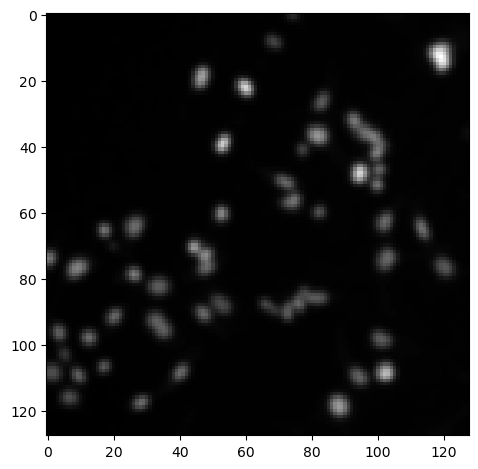

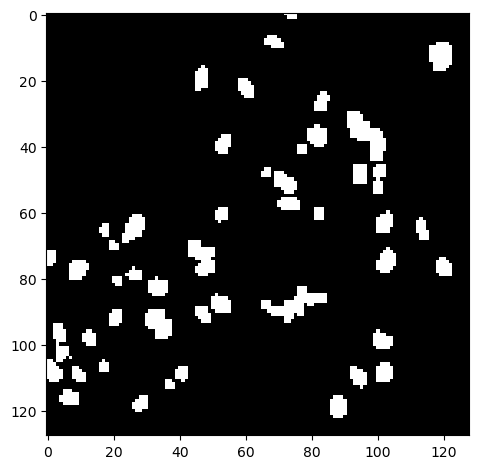

In [6]:
# Check if training data looks all right
# DOUBLE CHECK MASKS!!
ix = random.randint(0, len(train_ids))

print(ix, train_ids[ix])
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [7]:
# allowing for hyperparam tuning
import keras_tuner as kt
hp = kt.HyperParameters()

In [8]:
def model_builder(hp):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    # here we're using the hyperparam for learning rate!
    model.compile(tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'), amsgrad= True), loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.3))

#     model.summary()
    
    return model
    

In [9]:
tuner = kt.RandomSearch(
    model_builder,
    objective = kt.Objective("mean_io_u", direction="max"),
    max_trials=5)

INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [10]:
# TURNING OFF STOP EARLY
tuner.search(X_train, Y_train, epochs=5, validation_split=0.2)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is ... and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is ... and the optimal learning rate for the optimizer
is 0.0017991073735913667.



In [11]:
model = tuner.hypermodel.build(best_hps)

2023-04-01 14:31:43.248163: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
## ADDING ADVERSARIAL ATTACK...
loss_object = tf.keras.losses.BinaryCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    input_image = tf.convert_to_tensor(np.reshape(input_image, (-1, 128, 128, 1)), dtype=tf.float32)
    input_label = np.reshape(input_label, (-1, 128, 128, 1))

#     Record operations for automatic differentiation??
    with tf.GradientTape() as tape:

        tape.watch(input_image)
        prediction = model(input_image)
        
        loss = loss_object(input_label, prediction)

#   # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)

    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    
    return signed_grad

In [13]:
# Get the input label of the image. -->  THIS NEEDS TO BE A LOOP THROUGH THE IMAGES!!
# WE CAN RANDOMIZE HOW MANY GET A PERTURBATION!!

pert = []

for i in range(len(X_train)):
    pert.append(create_adversarial_pattern(X_train[i],Y_train[i]))


In [14]:
# making a function for adding peterubation!!!!!
def addingep (ep):
    newtrain = []

    for i in range(len(X_train)): 
        pert[i] = tf.reshape(pert[i], [1, 128, 128])
        new = X_train[i] + ep* pert[i] * 0.5 + 0.5
        newtrain.append(np.squeeze(new.numpy()))

    newtrain = np.asarray(newtrain)
    newtrain = np.squeeze(newtrain)
    
    return newtrain

In [15]:
# Generates a new X_train
newtrain_2 = addingep(2)

In [16]:
X_train.shape

(1809, 128, 128)

In [17]:
newtrain_2.shape

(1809, 128, 128)

95


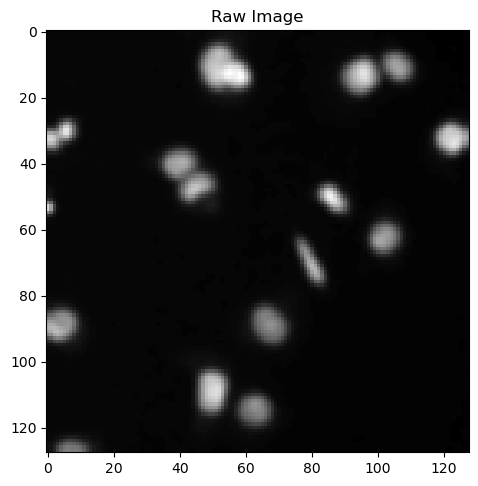

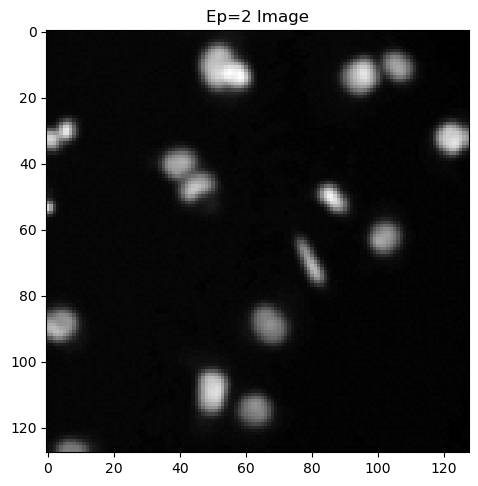

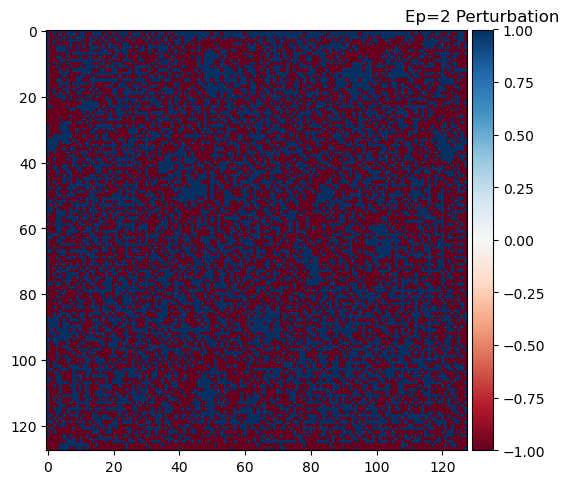

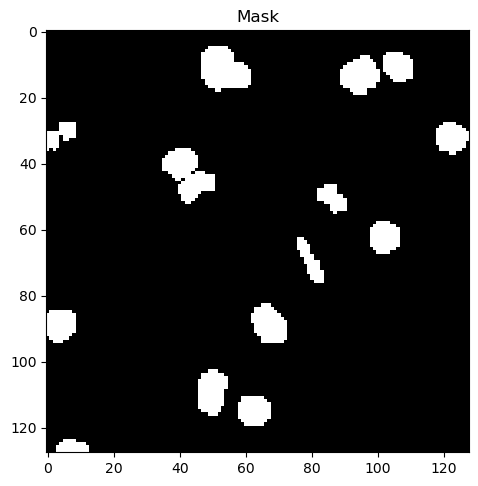

In [18]:
# Let's visualize what we've done here...
# Perform a sanity check on some random training samples
ix = random.randint(0, len(newtrain_2))
print(ix)
imshow(X_train[ix])
plt.title('Raw Image')
plt.show()
imshow(newtrain_2[ix].astype('uint8'))
plt.title('Ep=2 Image')
plt.show()
imshow(np.squeeze(pert[ix]))
plt.title('Ep=2 Perturbation')
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.title('Mask')
plt.show()

In [19]:
# increasing epoch val to 50!!
# tf.config.run_functions_eagerly(True)
history = model.fit(newtrain_2, Y_train, epochs=50, validation_split=0.2)

Epoch 1/50
46/46 [==============================] - 64s 1s/step - loss: 0.3077 - binary_io_u: 0.5483 - val_loss: 0.1898 - val_binary_io_u: 0.7611
Epoch 2/50
46/46 [==============================] - 67s 1s/step - loss: 0.1614 - binary_io_u: 0.7732 - val_loss: 0.1536 - val_binary_io_u: 0.8086
Epoch 3/50
46/46 [==============================] - 65s 1s/step - loss: 0.1477 - binary_io_u: 0.7925 - val_loss: 0.1359 - val_binary_io_u: 0.8205
Epoch 4/50
46/46 [==============================] - 62s 1s/step - loss: 0.1316 - binary_io_u: 0.8134 - val_loss: 0.1123 - val_binary_io_u: 0.8395
Epoch 5/50
46/46 [==============================] - 64s 1s/step - loss: 0.1188 - binary_io_u: 0.8305 - val_loss: 0.1068 - val_binary_io_u: 0.8464
Epoch 6/50
46/46 [==============================] - 61s 1s/step - loss: 0.1197 - binary_io_u: 0.8277 - val_loss: 0.1033 - val_binary_io_u: 0.8640
Epoch 7/50
46/46 [==============================] - 64s 1s/step - loss: 0.1078 - binary_io_u: 0.8446 - val_loss: 0.0974 - va

In [20]:
val_acc_per_epoch = history.history['val_binary_io_u']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 40


In [21]:
# use the best number of epochs
hypermodel = tuner.hypermodel.build(best_hps)

# FROM = 2023/03/30
# # REMEMBER TO CHANGE THE NAME OF THE MODEL!!
checkpointer = ModelCheckpoint('model-UNetEp=2Model_20230330.h5', verbose=1, save_best_only=True)
# Retrain the model--> USE THE NEW_TRAIN
result = hypermodel.fit(newtrain_2, Y_train, epochs=best_epoch, validation_split=0.2, callbacks=[checkpointer])


Epoch 1/40
46/46 [==============================] - ETA: 0s - loss: 0.2648 - binary_io_u_1: 0.6185
Epoch 1: val_loss improved from inf to 0.13846, saving model to model-UNetEp=2Model_20230330.h5
46/46 [==============================] - 64s 1s/step - loss: 0.2648 - binary_io_u_1: 0.6185 - val_loss: 0.1385 - val_binary_io_u_1: 0.8007
Epoch 2/40
46/46 [==============================] - ETA: 0s - loss: 0.1527 - binary_io_u_1: 0.7839
Epoch 2: val_loss improved from 0.13846 to 0.11925, saving model to model-UNetEp=2Model_20230330.h5
46/46 [==============================] - 63s 1s/step - loss: 0.1527 - binary_io_u_1: 0.7839 - val_loss: 0.1193 - val_binary_io_u_1: 0.8187
Epoch 3/40
46/46 [==============================] - ETA: 0s - loss: 0.1257 - binary_io_u_1: 0.8207
Epoch 3: val_loss improved from 0.11925 to 0.10372, saving model to model-UNetEp=2Model_20230330.h5
46/46 [==============================] - 62s 1s/step - loss: 0.1257 - binary_io_u_1: 0.8207 - val_loss: 0.1037 - val_binary_io_u_

In [24]:
# ALTER THE NAMING CONVENTIONS..
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables--> these two need to be diff
    tr_acc = hist.history['binary_io_u_1']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_binary_io_u_1']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Binary IOU')
    plt.xlabel('Epochs')
    plt.ylabel('Binary IOU')
    plt.legend()

    # change the title!!
    plt.suptitle("Unet trained with Ep =2", fontsize=30)
    plt.tight_layout
    plt.savefig('model-UNetEp=2Model_20230330.png')
    plt.show()

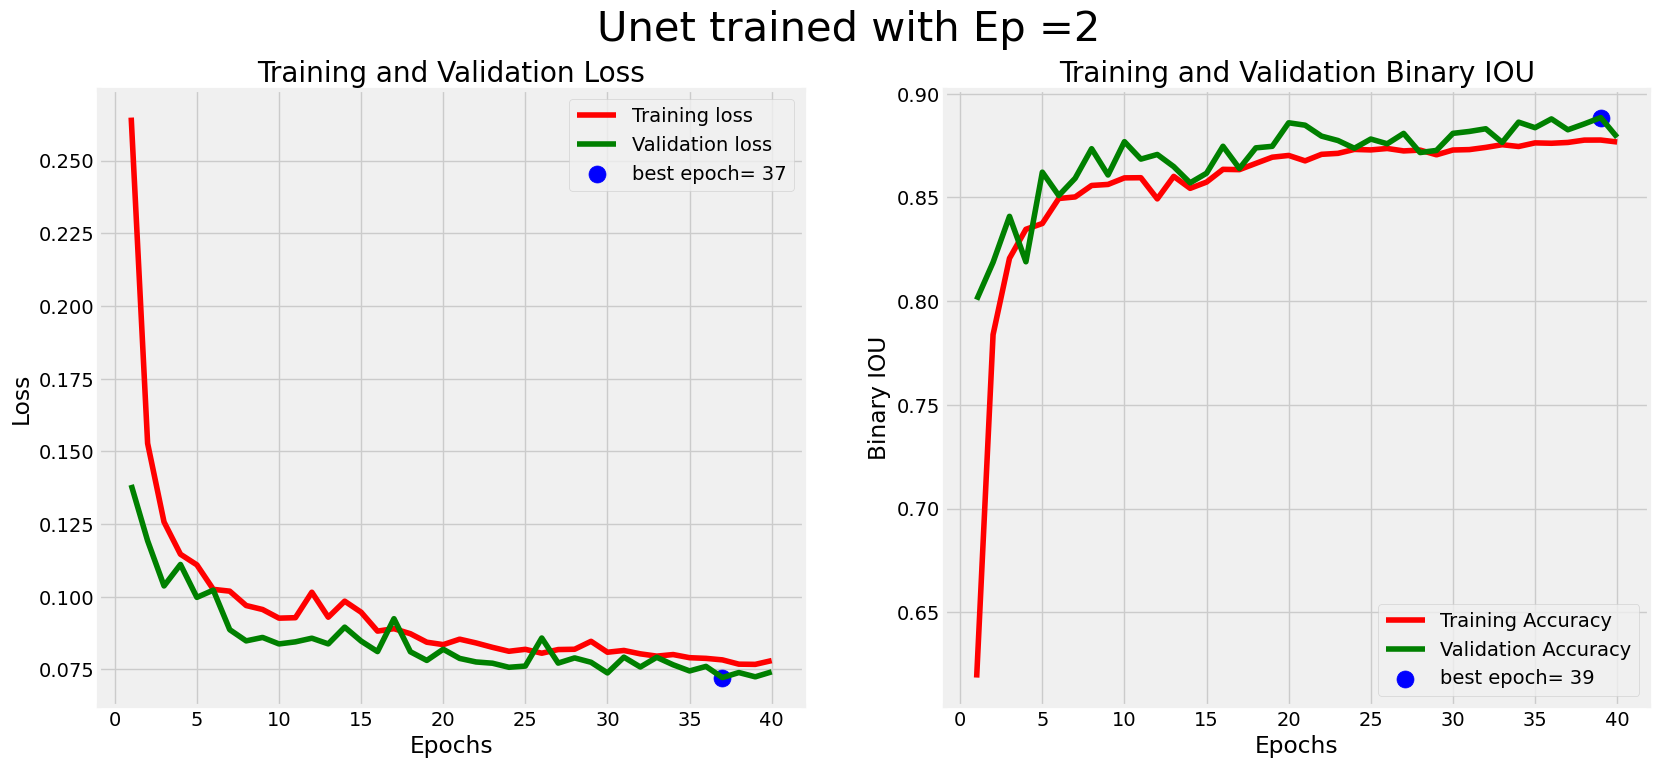

In [25]:
# results.history
plot_training(result)

In [ ]:
# we could stop here...